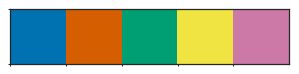

In [1]:
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_venn as vn
import seaborn as sns
from scipy import stats
from rpy2 import robjects as robj

#load r magics
%load_ext rpy2.ipython
#auto converts pulled R dataframes into pandas dataframes!
robj.pandas2ri.activate()

%matplotlib inline
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=2, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7'])
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

In [2]:
%%R
library(oligo)
cel <- paste('cel', list.celfiles('cel'), sep='/')
cel <- read.celfiles(cel)
samples <- rep(c('wt', 'drought'), each=4)
sampleNames(cel) <- paste(samples, rep(1:4, 2), sep='_')
sampleNames(cel)

/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: BiocGenerics

  warnings.warn(x, RRuntimeWarning)
/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: parallel

  warnings.warn(x, RRuntimeWarning)
/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘BiocGenerics’


  warnings.warn(x, RRuntimeWarning)
/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


  warnings.warn(x, RRuntimeWarning)
/home/matthew/anaconda3/envs/ml

Reading in : cel/Linster_180213_wt_1_ctrl_GSM1595796.CEL
Reading in : cel/Linster_180213_wt_2_ctrl_GSM1595797.CEL
Reading in : cel/Linster_180213_wt_3_ctrl_GSM1595798.CEL
Reading in : cel/Linster_180213_wt_4_ctrl_GSM1595803.CEL
Reading in : cel/Linster_180213_wt_drought_1_GSM1595799.CEL
Reading in : cel/Linster_180213_wt_drought_2_GSM1595800.CEL
Reading in : cel/Linster_180213_wt_drought_3_GSM1595801.CEL
Reading in : cel/Linster_180213_wt_drought_4_GSM1595802.CEL
[1] "wt_1"      "wt_2"      "wt_3"      "wt_4"      "drought_1" "drought_2"
[7] "drought_3" "drought_4"


In [5]:
%%R
library(limma)
sessionInfo()

/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘limma’


  warnings.warn(x, RRuntimeWarning)
/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following object is masked from ‘package:oligo’:

    backgroundCorrect


  warnings.warn(x, RRuntimeWarning)
/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following object is masked from ‘package:BiocGenerics’:

    plotMA


  warnings.warn(x, RRuntimeWarning)


R version 3.4.1 (2017-06-30)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 16.04.4 LTS

Matrix products: default
BLAS: /home/matthew/anaconda3/envs/ml_python35/lib/R/lib/libRblas.so
LAPACK: /home/matthew/anaconda3/envs/ml_python35/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_GB.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_GB.UTF-8        LC_COLLATE=en_GB.UTF-8    
 [5] LC_MONETARY=en_GB.UTF-8    LC_MESSAGES=en_GB.UTF-8   
 [7] LC_PAPER=en_GB.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_GB.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] stats4    parallel  tools     stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] limma_3.34.6             pd.aragene.1.0.st_3.12.0 DBI_0.8                 
 [4] RSQLite_1.1-2            oligo_1.42.0             Biostrings_2.46.0       
 [7] XVector_0.18.0           IRanges_2.12.0  

In [3]:
%%R
rma_norm <- rma(cel, target='core')
featureData(rma_norm) <- getNetAffx(rma_norm, 'transcript')

Background correcting
Normalizing
Calculating Expression


In [4]:
%%R
design <- model.matrix(~0 + samples)
rownames(design) <- sampleNames(rma_norm)
colnames(design) <- c('drought', 'wt')
design

          drought wt
wt_1            0  1
wt_2            0  1
wt_3            0  1
wt_4            0  1
drought_1       1  0
drought_2       1  0
drought_3       1  0
drought_4       1  0
attr(,"assign")
[1] 1 1
attr(,"contrasts")
attr(,"contrasts")$samples
[1] "contr.treatment"



In [5]:
%%R -o drought
library(limma)
fit <- lmFit(rma_norm, design)
fit <- eBayes(fit)
cFit <- contrasts.fit(fit, contrast=makeContrasts(drought - wt, levels=design))
cFit <- eBayes(cFit)
drought <- topTable(cFit, n=Inf)
drought <- drought[drought$category == "main",
                   c('probesetid', 'mrnaassignment', 'logFC', 'AveExpr', 'adj.P.Val')]

/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘limma’


  warnings.warn(x, RRuntimeWarning)
/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following object is masked from ‘package:oligo’:

    backgroundCorrect


  warnings.warn(x, RRuntimeWarning)
/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following object is masked from ‘package:BiocGenerics’:

    plotMA


  warnings.warn(x, RRuntimeWarning)


In [6]:
annot = drought.mrnaassignment.str.split('\s+///\s+', expand=True)
annot = annot.where(
    annot.apply(lambda col: col.str.contains('ENSEMBL'), axis=0))
annot['probesetid'] = drought['probesetid']
annot = pd.melt(annot, id_vars='probesetid')
annot = (annot.drop('variable', axis=1)
              .dropna()
              .sort_values('probesetid'))
annot = annot.join(
    annot.value.str.split('\s+//\s+', expand=True)[[0, 2]]
)
annot = annot.drop('value', axis=1)
annot.columns = ['probsetid', 'transcript_id', 'desc']
annot = annot.join(
    annot['desc'].str.split('\s*[a-z]+:', expand=True)[[2, 3, 5]],
)
annot = annot.drop('desc', axis=1)
annot.columns = [
    'probesetid', 'transcript_id', 'loc', 'gene_id', 'description']
annot.head()

,probesetid,transcript_id,loc,gene_id,description
33970,13334158,AT1G01010.1,TAIR10:1:3631:5899:1,AT1G01010,NAC domain containing protein 1
91818,13334167,AT1G01040.2,TAIR10:1:23416:31120:1,AT1G01040,dicer-like 1
35012,13334167,AT1G01040.1,TAIR10:1:23146:31227:1,AT1G01040,dicer-like 1
27621,13334192,AT1G01073.1,TAIR10:1:44677:44787:1,AT1G01073,unknown protein\x3b FUNCTIONS IN\x3a molecular...
51210,13334194,AT1G01110.2,TAIR10:1:52239:54692:1,AT1G01110,IQ-domain 18


In [7]:
drought_annot = annot.merge(
    drought[['probesetid', 'logFC', 'AveExpr', 'adj.P.Val']],
    on='probesetid'
)
drought_annot.head()

,probesetid,transcript_id,loc,gene_id,description,logFC,AveExpr,adj.P.Val
0,13334158,AT1G01010.1,TAIR10:1:3631:5899:1,AT1G01010,NAC domain containing protein 1,0.652425,6.235776,0.064690
1,13334167,AT1G01040.2,TAIR10:1:23416:31120:1,AT1G01040,dicer-like 1,0.572298,6.467987,0.086081
2,13334167,AT1G01040.1,TAIR10:1:23146:31227:1,AT1G01040,dicer-like 1,0.572298,6.467987,0.086081
3,13334192,AT1G01073.1,TAIR10:1:44677:44787:1,AT1G01073,unknown protein\x3b FUNCTIONS IN\x3a molecular...,0.010908,2.080683,0.973711
4,13334194,AT1G01110.2,TAIR10:1:52239:54692:1,AT1G01110,IQ-domain 18,0.115138,6.094045,0.767961


In [10]:
%%bash
source activate jupyter_python3

g4predict intra \
  -f /home/matthew/Documents/genomes/tair10/fasta/tair10_genome.fa \
  -b /tmp/tair10_g4.bed \
  -s \
  -F \
  -tmin 2 \
  -tmax 2 \
  -lmin 1 \
  -lmax 7

INFO:root:Output from G4Predict
INFO:root:Parsing command line arguments
INFO:root:Running in mode: intra
INFO:root:Parameters:
{       'bed': '/tmp/tair10_g4.bed',
        'fasta': '/home/matthew/Documents/genomes/tair10/fasta/tair10_genome.fa',
        'filter_overlapping': True,
        'func': <function parse_args.<locals>.intra at 0x7f5072a4ebf8>,
        'merge_overlapping': False,
        'write_bed12': False,
        'write_bed6': True}
INFO:root:G4 Parameters: 
{       'bulge_kwargs': {'bulges_allowed': 0, 'start': 1, 'stop': 5},
        'inter_kwargs': {'start': 2, 'stop': 3},
        'loop_kwargs_list': [       {'allow_G': 1, 'start': 1, 'stop': 7},
                                    {'allow_G': 1, 'start': 1, 'stop': 7},
                                    {'allow_G': 1, 'start': 1, 'stop': 7}],
        'score_kwargs': {       'bulge_pen_factor': 5,
                                'loop_pen_factor': 1.5,
                                'tetrad_score_factor': 20},
        '

In [11]:
%%bash
source activate cgat_python2

cgat gtf2gtf --method=merge-transcripts --filter=proteincoding \
  -I /home/matthew/Documents/genomes/tair10/gff/Araport11_GFF3_genes_transposons.201606.gtf \
  -L /dev/null |
awk -v OFS='\t' '{print $1, $4 - 1, $5, $10, ".", $7}' | sed 's/[";]//g' > /tmp/araport11_genes.bed

In [12]:
%%bash
source activate jupyter_python3

join -j 1 -t $'\t' <( 
    bedtools intersect -c -s -F 1 \
      -a /tmp/araport11_genes.bed \
      -b /tmp/tair10_g4.bed | \
    awk -v OFS='\t' '{print $4,$7,$7/($3-$2)*1000}') \
           <(
    bedtools intersect -c -S -F 1 \
      -a /tmp/araport11_genes.bed \
      -b /tmp/tair10_g4.bed | \
    awk -v OFS='\t' '{print $4,$7,$7/($3-$2)*1000}') \
    > /tmp/genic_g4_counts.tsv

In [14]:
g4_counts = pd.read_table('/tmp/genic_g4_counts.tsv',
                          sep='\t',
                          names=['gene_id', 'coding_g4', 'coding_g4_dens',
                                 'template_g4', 'template_g4_dens'])
g4_counts_exon = pd.read_table(
    '../tair10_g4_maximal_density/exonic_g4_counts.tsv',
    sep='\t',
    names=['gene_id',
           'exon_coding_g4', 'exon_coding_g4_dens',
           'exon_template_g4', 'exon_template_g4_dens']
)
g4_counts_intron = pd.read_table(
    '../tair10_g4_maximal_density/intronic_g4_counts.tsv',
    sep='\t',
    names=['gene_id',
           'intron_coding_g4', 'intron_coding_g4_dens',
           'intron_template_g4', 'intron_template_g4_dens']
)
g4_counts_cds = pd.read_table(
    '../tair10_g4_maximal_density/cds_g4_counts.tsv',
    sep='\t',
    names=['gene_id',
           'cds_coding_g4', 'cds_coding_g4_dens',
           'cds_template_g4', 'cds_template_g4_dens']
)
g4_counts_utr5 = pd.read_table(
    '../tair10_g4_maximal_density/utr5_g4_counts.tsv',
    sep='\t',
    names=['gene_id',
           'utr5_coding_g4', 'utr5_coding_g4_dens',
           'utr5_template_g4', 'utr5_template_g4_dens']
)
g4_counts_utr3 = pd.read_table(
    '../tair10_g4_maximal_density/utr3_g4_counts.tsv',
    sep='\t',
    names=['gene_id',
           'utr3_coding_g4', 'utr3_coding_g4_dens',
           'utr3_template_g4', 'utr3_template_g4_dens']
)
g4_counts_exon_intron = g4_counts_exon.merge(g4_counts_intron, how='outer').fillna(0)
g4_counts_exon_intron = g4_counts_exon_intron.merge(g4_counts_cds, how='outer').fillna(0)
g4_counts_exon_intron = g4_counts_exon_intron.merge(g4_counts_utr5, how='outer').fillna(0)
g4_counts_exon_intron = g4_counts_exon_intron.merge(g4_counts_utr3, how='outer').fillna(0)
drought_g4_dens = drought_annot.merge(g4_counts, on='gene_id').merge(g4_counts_exon_intron, on='gene_id')
drought_g4_dens.head(n=10)

,probesetid,transcript_id,loc,gene_id,description,logFC,AveExpr,adj.P.Val,coding_g4,coding_g4_dens,...,cds_template_g4,cds_template_g4_dens,utr5_coding_g4,utr5_coding_g4_dens,utr5_template_g4,utr5_template_g4_dens,utr3_coding_g4,utr3_coding_g4_dens,utr3_template_g4,utr3_template_g4_dens
0,13334158,AT1G01010.1,TAIR10:1:3631:5899:1,AT1G01010,NAC domain containing protein 1,0.652425,6.235776,0.064690,1,0.440723,...,2.0,1.550390,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,13334167,AT1G01040.2,TAIR10:1:23416:31120:1,AT1G01040,dicer-like 1,0.572298,6.467987,0.086081,9,1.110150,...,2.0,0.348857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,13334167,AT1G01040.1,TAIR10:1:23146:31227:1,AT1G01040,dicer-like 1,0.572298,6.467987,0.086081,9,1.110150,...,2.0,0.348857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,13334194,AT1G01110.2,TAIR10:1:52239:54692:1,AT1G01110,IQ-domain 18,0.115138,6.094045,0.767961,2,0.718133,...,4.0,2.525250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,13334194,AT1G01110.1,TAIR10:1:52869:54685:1,AT1G01110,IQ-domain 18,0.115138,6.094045,0.767961,2,0.718133,...,4.0,2.525250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,13334204,AT1G01160.2,TAIR10:1:72357:74096:1,AT1G01160,GRF1-interacting factor 2,0.690581,8.228352,0.014406,1,0.568828,...,2.0,2.898550,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,13334204,AT1G01160.1,TAIR10:1:72339:74096:1,AT1G01160,GRF1-interacting factor 2,0.690581,8.228352,0.014406,1,0.568828,...,2.0,2.898550,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,13361898,AT1G01160.2,TAIR10:1:72357:74096:1,AT1G01160,GRF1-interacting factor 2,0.067711,8.646389,0.721361,1,0.568828,...,2.0,2.898550,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,13361898,AT1G01160.1,TAIR10:1:72339:74096:1,AT1G01160,GRF1-interacting factor 2,0.067711,8.646389,0.721361,1,0.568828,...,2.0,2.898550,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,13334204,AT1G01170.2,TAIR10:1:73931:74731:-1,AT1G01170,Protein of unknown function (DUF1138),0.690581,8.228352,0.014406,0,0.000000,...,1.0,3.968250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
drought_g4_dens['upreg'] = ((drought_g4_dens['adj.P.Val'] < 0.05) &
                       (drought_g4_dens.logFC > 0.5))
drought_g4_dens['strong_upreg'] = ((drought_g4_dens['adj.P.Val'] < 0.05) &
                              (drought_g4_dens.logFC > 1))
drought_g4_dens['downreg'] = ((drought_g4_dens['adj.P.Val'] < 0.05) &
                       (drought_g4_dens.logFC < -0.5))
drought_g4_dens['strong_downreg'] = ((drought_g4_dens['adj.P.Val'] < 0.05) &
                              (drought_g4_dens.logFC < -1))
drought_g4_dens['notDE'] = ~drought_g4_dens.upreg & ~drought_g4_dens.downreg
drought_g4_dens['cond'] = drought_g4_dens[['upreg', 'downreg', 'notDE']].idxmax(1)
drought_g4_dens['strong_cond'] = drought_g4_dens.strong_upreg | drought_g4_dens.strong_downreg

In [16]:
drought_g4_dens.strong_downreg.sum()

984

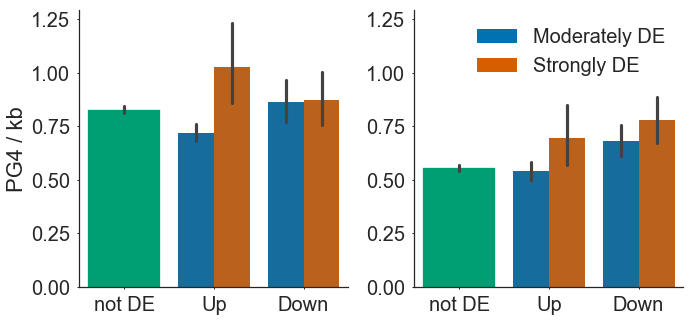

In [17]:
drought_g4_long = pd.melt(
    drought_g4_dens.drop_duplicates(subset=['gene_id']),
    id_vars=['gene_id', 'logFC', 'cond', 'strong_cond'],
    value_vars=['coding_g4_dens', 'template_g4_dens'],
    var_name='strand', value_name='g4_density')

g = sns.factorplot(x='cond',
                   y='g4_density',
                   hue='strong_cond',
                   col='strand',
                   kind='bar',
                   order=['notDE', 'upreg', 'downreg'],
                   data=drought_g4_long,
                   legend=False,
                   size=5)
w = g.axes.squeeze()[0].patches[0].get_width()
g.axes.squeeze()[0].patches[0].set_color(pal[2])
g.axes.squeeze()[0].patches[0].set_color(pal[2])
g.axes.squeeze()[0].patches[0].set_width(w * 2)
g.axes.squeeze()[0].lines[0].set_xdata([0, 0])
g.axes.squeeze()[1].patches[0].set_color(pal[2])
g.axes.squeeze()[1].patches[0].set_width(w * 2)
g.axes.squeeze()[1].lines[0].set_xdata([0, 0])
g.axes.squeeze()[0].set_title('')
g.axes.squeeze()[1].set_title('')
g.set_xlabels('')
g.set_ylabels('PG4 / kb')
g.set_xticklabels(['not DE', 'Up', 'Down'])
a1, = plt.bar([0], [0], 0, color=pal[0])
a2, = plt.bar([0], [0], 0, color=pal[1])
plt.legend([a1, a2], ['Moderately DE', 'Strongly DE'])
plt.tight_layout()
plt.savefig('drought_g4_dens_gene_body.svg')
plt.show()

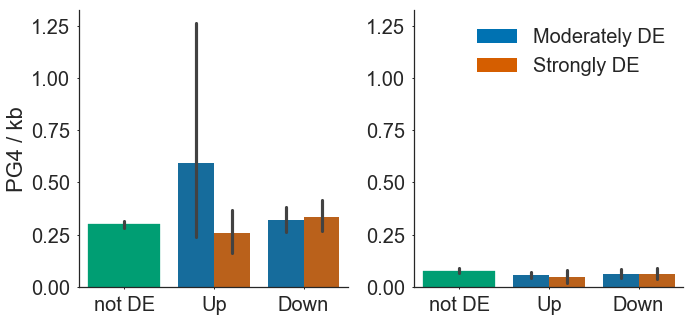

In [18]:
drought_g4_long = pd.melt(
    drought_g4_dens.drop_duplicates(subset=['gene_id']),
    id_vars=['gene_id', 'logFC', 'cond', 'strong_cond'],
    value_vars=['intron_coding_g4_dens', 'intron_template_g4_dens'],
    var_name='strand', value_name='g4_density')

g = sns.factorplot(x='cond',
                   y='g4_density',
                   hue='strong_cond',
                   col='strand',
                   kind='bar',
                   order=['notDE', 'upreg', 'downreg'],
                   data=drought_g4_long,
                   legend=False,
                   size=5)
w = g.axes.squeeze()[0].patches[0].get_width()
g.axes.squeeze()[0].patches[0].set_color(pal[2])
g.axes.squeeze()[0].patches[0].set_color(pal[2])
g.axes.squeeze()[0].patches[0].set_width(w * 2)
g.axes.squeeze()[0].lines[0].set_xdata([0, 0])
g.axes.squeeze()[1].patches[0].set_color(pal[2])
g.axes.squeeze()[1].patches[0].set_width(w * 2)
g.axes.squeeze()[1].lines[0].set_xdata([0, 0])
g.axes.squeeze()[0].set_title('')
g.axes.squeeze()[1].set_title('')
g.set_xlabels('')
g.set_ylabels('PG4 / kb')
g.set_xticklabels(['not DE', 'Up', 'Down'])
a1, = plt.bar([0], [0], 0, color=pal[0])
a2, = plt.bar([0], [0], 0, color=pal[1])
plt.legend([a1, a2], ['Moderately DE', 'Strongly DE'])
plt.tight_layout()
plt.savefig('drought_g4_dens_intron.svg')
plt.show()

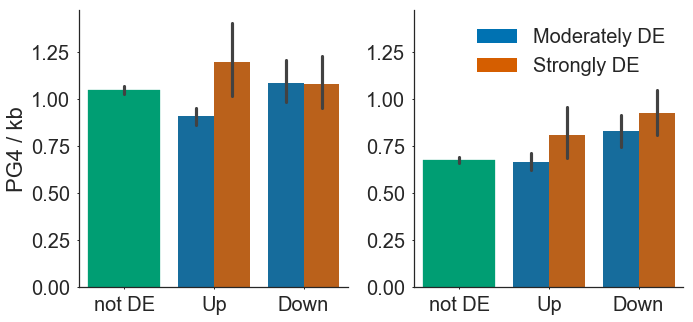

In [19]:
drought_g4_long = pd.melt(
    drought_g4_dens.drop_duplicates(subset=['gene_id']),
    id_vars=['gene_id', 'logFC', 'cond', 'strong_cond'],
    value_vars=['exon_coding_g4_dens', 'exon_template_g4_dens'],
    var_name='strand', value_name='g4_density')

g = sns.factorplot(x='cond',
                   y='g4_density',
                   hue='strong_cond',
                   col='strand',
                   kind='bar',
                   order=['notDE', 'upreg', 'downreg'],
                   data=drought_g4_long,
                   legend=False,
                   size=5)
w = g.axes.squeeze()[0].patches[0].get_width()
g.axes.squeeze()[0].patches[0].set_color(pal[2])
g.axes.squeeze()[0].patches[0].set_color(pal[2])
g.axes.squeeze()[0].patches[0].set_width(w * 2)
g.axes.squeeze()[0].lines[0].set_xdata([0, 0])
g.axes.squeeze()[1].patches[0].set_color(pal[2])
g.axes.squeeze()[1].patches[0].set_width(w * 2)
g.axes.squeeze()[1].lines[0].set_xdata([0, 0])
g.axes.squeeze()[0].set_title('')
g.axes.squeeze()[1].set_title('')
g.set_xlabels('')
g.set_ylabels('PG4 / kb')
g.set_xticklabels(['not DE', 'Up', 'Down'])
ax = g.axes.squeeze()[1]
a1, = plt.bar([0], [0], 0, color=pal[0])
a2, = plt.bar([0], [0], 0, color=pal[1])
plt.legend([a1, a2], ['Moderately DE', 'Strongly DE'])
plt.tight_layout()
plt.savefig('drought_g4_dens_exon.svg')
plt.show()

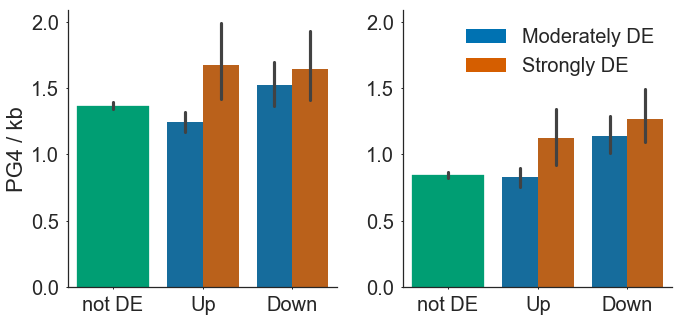

In [20]:
drought_g4_long = pd.melt(
    drought_g4_dens.drop_duplicates(subset=['gene_id']),
    id_vars=['gene_id', 'logFC', 'cond', 'strong_cond'],
    value_vars=['cds_coding_g4_dens', 'cds_template_g4_dens'],
    var_name='strand', value_name='g4_density')

g = sns.factorplot(x='cond',
                   y='g4_density',
                   hue='strong_cond',
                   col='strand',
                   kind='bar',
                   order=['notDE', 'upreg', 'downreg'],
                   data=drought_g4_long,
                   legend=False,
                   size=5)
w = g.axes.squeeze()[0].patches[0].get_width()
g.axes.squeeze()[0].patches[0].set_color(pal[2])
g.axes.squeeze()[0].patches[0].set_color(pal[2])
g.axes.squeeze()[0].patches[0].set_width(w * 2)
g.axes.squeeze()[0].lines[0].set_xdata([0, 0])
g.axes.squeeze()[1].patches[0].set_color(pal[2])
g.axes.squeeze()[1].patches[0].set_width(w * 2)
g.axes.squeeze()[1].lines[0].set_xdata([0, 0])
g.axes.squeeze()[0].set_title('')
g.axes.squeeze()[1].set_title('')
g.set_xlabels('')
g.set_ylabels('PG4 / kb')
g.set_xticklabels(['not DE', 'Up', 'Down'])
a1, = ax.bar([0], [0], 0, color=pal[0])
a2, = ax.bar([0], [0], 0, color=pal[1])
plt.legend([a1, a2], ['Moderately DE', 'Strongly DE'])
plt.tight_layout()
plt.savefig('drought_g4_dens_cds.svg')
plt.show()

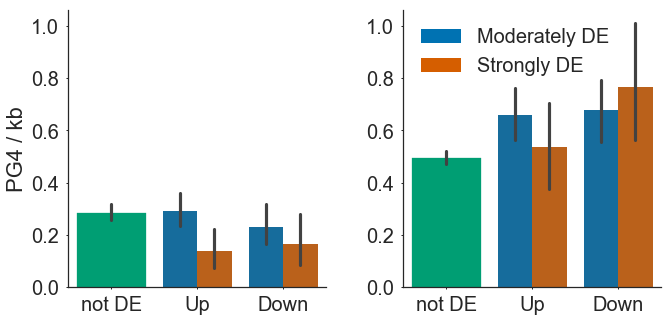

In [21]:
drought_g4_long = pd.melt(
    drought_g4_dens.drop_duplicates(subset=['gene_id']),
    id_vars=['gene_id', 'logFC', 'cond', 'strong_cond'],
    value_vars=['utr5_coding_g4_dens', 'utr5_template_g4_dens'],
    var_name='strand', value_name='g4_density')

g = sns.factorplot(x='cond',
                   y='g4_density',
                   hue='strong_cond',
                   col='strand',
                   kind='bar',
                   order=['notDE', 'upreg', 'downreg'],
                   data=drought_g4_long,
                   legend=False,
                   size=5)
w = g.axes.squeeze()[0].patches[0].get_width()
g.axes.squeeze()[0].patches[0].set_color(pal[2])
g.axes.squeeze()[0].patches[0].set_color(pal[2])
g.axes.squeeze()[0].patches[0].set_width(w * 2)
g.axes.squeeze()[0].lines[0].set_xdata([0, 0])
g.axes.squeeze()[1].patches[0].set_color(pal[2])
g.axes.squeeze()[1].patches[0].set_width(w * 2)
g.axes.squeeze()[1].lines[0].set_xdata([0, 0])
g.axes.squeeze()[0].set_title('')
g.axes.squeeze()[1].set_title('')
g.set_xlabels('')
g.set_ylabels('PG4 / kb')
g.set_xticklabels(['not DE', 'Up', 'Down'])
a1, = ax.bar([0], [0], 0, color=pal[0])
a2, = ax.bar([0], [0], 0, color=pal[1])
plt.legend([a1, a2], ['Moderately DE', 'Strongly DE'])
plt.tight_layout()
plt.savefig('drought_g4_dens_utr5.svg')
plt.show()

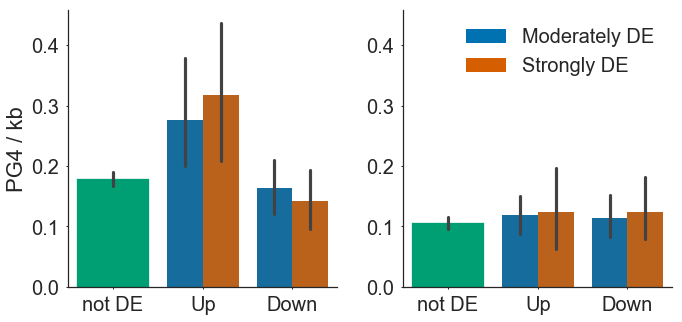

In [22]:
drought_g4_long = pd.melt(
    drought_g4_dens.drop_duplicates(subset=['gene_id']),
    id_vars=['gene_id', 'logFC', 'cond', 'strong_cond'],
    value_vars=['utr3_coding_g4_dens', 'utr3_template_g4_dens'],
    var_name='strand', value_name='g4_density')

g = sns.factorplot(x='cond',
                   y='g4_density',
                   hue='strong_cond',
                   col='strand',
                   kind='bar',
                   order=['notDE', 'upreg', 'downreg'],
                   data=drought_g4_long,
                   legend=False,
                   size=5)
w = g.axes.squeeze()[0].patches[0].get_width()
g.axes.squeeze()[0].patches[0].set_color(pal[2])
g.axes.squeeze()[0].patches[0].set_color(pal[2])
g.axes.squeeze()[0].patches[0].set_width(w * 2)
g.axes.squeeze()[0].lines[0].set_xdata([0, 0])
g.axes.squeeze()[1].patches[0].set_color(pal[2])
g.axes.squeeze()[1].patches[0].set_width(w * 2)
g.axes.squeeze()[1].lines[0].set_xdata([0, 0])
g.axes.squeeze()[0].set_title('')
g.axes.squeeze()[1].set_title('')
g.set_xlabels('')
g.set_ylabels('PG4 / kb')
g.set_xticklabels(['not DE', 'Up', 'Down'])
a1, = plt.bar([0], [0], 0, color=pal[0])
a2, = plt.bar([0], [0], 0, color=pal[1])
plt.legend([a1, a2], ['Moderately DE', 'Strongly DE'])
plt.tight_layout()
plt.savefig('drought_g4_dens_utr3.svg')
plt.show()

In [32]:
nmm = pd.read_csv('./tair10_nmm.csv', index_col=0)
nmm['upreg'] = ((nmm.PPLR_NMM_6h_vs_DMSO_6h > 0.95) &
                       (nmm.logFC_NMM_6h_vs_DMSO_6h > 0.5))
nmm['strong_upreg'] = ((nmm.PPLR_NMM_6h_vs_DMSO_6h > 0.95) &
                             (nmm.logFC_NMM_6h_vs_DMSO_6h > 1))
nmm['downreg'] = ((nmm.PPLR_NMM_6h_vs_DMSO_6h < 0.05) &
                         (nmm.logFC_NMM_6h_vs_DMSO_6h < -0.5))
nmm['strong_downreg'] = ((nmm.PPLR_NMM_6h_vs_DMSO_6h < 0.05) &
                               (nmm.logFC_NMM_6h_vs_DMSO_6h < -1))
nmm['notDE'] = ~nmm.upreg & ~nmm.downreg
nmm['cond'] = nmm[['upreg', 'downreg', 'notDE']].idxmax(1)
nmm['strong_cond'] = nmm.strong_upreg | nmm.strong_downreg
nmm.head()

,probe_cluster_id,transcript_id,loc,gene_id,description,DMSO_24h,DMSO_6h,NMM_24h,NMM_6h,logFC_NMM_6h_vs_DMSO_6h,...,PPLR_NMM_6h_vs_DMSO_6h,PPLR_NMM_24h_vs_DMSO_24h,PPLR_NMM_24h_vs_NMM_6h,upreg,strong_upreg,downreg,strong_downreg,notDE,cond,strong_cond
0,13334158,AT1G01010.1,TAIR10:1:3631:5899:1,AT1G01010,NAC domain containing protein 1,6.328143,6.399972,6.584596,6.424296,0.024324,...,0.564014,0.955349,0.866938,False,False,False,False,True,notDE,False
1,13334167,AT1G01040.2,TAIR10:1:23416:31120:1,AT1G01040,dicer-like 1,6.732463,6.735422,6.822553,6.503099,-0.232322,...,0.013710,0.803795,0.999479,False,False,False,False,True,notDE,False
2,13334167,AT1G01040.1,TAIR10:1:23146:31227:1,AT1G01040,dicer-like 1,6.732463,6.735422,6.822553,6.503099,-0.232322,...,0.013710,0.803795,0.999479,False,False,False,False,True,notDE,False
3,13334192,AT1G01073.1,TAIR10:1:44677:44787:1,AT1G01073,unknown protein\x3b FUNCTIONS IN\x3a molecular...,3.939582,3.949629,3.992714,4.092797,0.143168,...,0.912347,0.692513,0.161645,False,False,False,False,True,notDE,False
4,13334194,AT1G01110.1,TAIR10:1:52869:54685:1,AT1G01110,IQ-domain 18,5.484441,5.501032,5.472346,5.473653,-0.027379,...,0.289995,0.403435,0.489347,False,False,False,False,True,notDE,False


In [33]:
nmm_drought_g4 = nmm.merge(drought_g4_dens, on='transcript_id', suffixes=['_nmm', '_drought'])

In [34]:
len(set(nmm_drought_g4.gene_id_nmm))

27358

778 27358 3848 1921
7.33963911988e-197


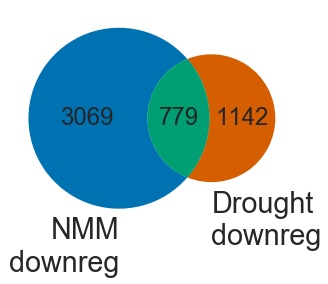

In [35]:
nmm_downreg = set(nmm_drought_g4.loc[nmm_drought_g4.downreg_nmm, 'gene_id_nmm'])
drought_downreg = set(nmm_drought_g4.loc[nmm_drought_g4.downreg_drought, 'gene_id_drought'])
print(len(nmm_downreg.intersection(drought_downreg)) - 1,
      len(set(nmm_drought_g4.gene_id_nmm)),
      len(nmm_downreg),
      len(drought_downreg))
print(stats.hypergeom.sf(
    len(nmm_downreg.intersection(drought_downreg)) - 1,
    len(set(nmm_drought_g4.gene_id_nmm)),
    len(nmm_downreg),
    len(drought_downreg),
))
venn = vn.venn2(
    [nmm_downreg, drought_downreg],
    set_labels=['NMM\ndownreg', 'Drought\ndownreg'],
    set_colors=pal[:2],
    alpha=1
)
venn.get_patch_by_id('11').set_color(pal[2])
plt.savefig('./venn_nmm_drought.svg')
plt.show()

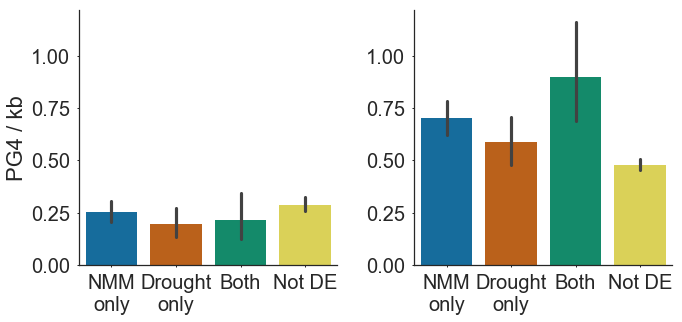

In [36]:
nmm_drought_g4_long = pd.melt(
    nmm_drought_g4.drop_duplicates(subset=['gene_id_nmm']),
    id_vars=['gene_id_nmm', 'downreg_nmm', 'downreg_drought'],
    value_vars=['utr5_coding_g4_dens', 'utr5_template_g4_dens'],
    var_name='strand', value_name='g4_density')
nmm_drought_g4_long['neither'] = ~(nmm_drought_g4_long.downreg_nmm | nmm_drought_g4_long.downreg_drought)
nmm_drought_g4_long['downreg_both'] = nmm_drought_g4_long.downreg_nmm & nmm_drought_g4_long.downreg_drought
nmm_drought_g4_long.loc[nmm_drought_g4_long.downreg_both, ['downreg_nmm', 'downreg_drought']] = False
nmm_drought_g4_long['cond'] = nmm_drought_g4_long[['downreg_nmm', 'downreg_drought', 'downreg_both', 'neither']].idxmax(1)

g = sns.factorplot(x='cond',
                   y='g4_density',
                   col='strand',
                   kind='bar',
                   data=nmm_drought_g4_long,
                   order=['downreg_nmm', 'downreg_drought', 'downreg_both', 'neither'],
                   size=5)
g.axes.squeeze()[0].set_title('')
g.axes.squeeze()[1].set_title('')
g.set_xlabels('')
g.set_xticklabels(['NMM\nonly', 'Drought\nonly', 'Both', 'Not DE'])
g.set_ylabels('PG4 / kb')
a1, = plt.bar([0], [0], 0, color=pal[0])
a2, = plt.bar([0], [0], 0, color=pal[1])
plt.tight_layout()
plt.savefig('venn_subsets_g4_5utr.svg')
plt.show()

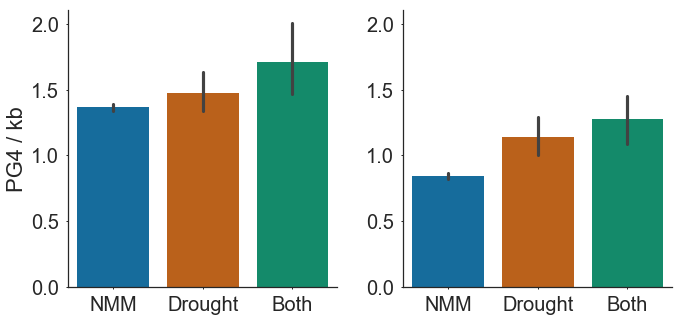

In [37]:
nmm_drought_g4_long = pd.melt(
    nmm_drought_g4.drop_duplicates(subset=['gene_id_nmm']),
    id_vars=['gene_id_nmm', 'downreg_nmm', 'downreg_drought'],
    value_vars=['cds_coding_g4_dens', 'cds_template_g4_dens'],
    var_name='strand', value_name='g4_density')
nmm_drought_g4_long['downreg_both'] = nmm_drought_g4_long.downreg_nmm & nmm_drought_g4_long.downreg_drought
nmm_drought_g4_long.loc[nmm_drought_g4_long.downreg_both, ['downreg_nmm', 'downreg_drought']] = False
nmm_drought_g4_long['cond'] = nmm_drought_g4_long[['downreg_nmm', 'downreg_drought', 'downreg_both']].idxmax(1)

g = sns.factorplot(x='cond',
                   y='g4_density',
                   col='strand',
                   kind='bar',
                   data=nmm_drought_g4_long,
                   order=['downreg_nmm', 'downreg_drought', 'downreg_both'],
                   size=5)
g.axes.squeeze()[0].set_title('')
g.axes.squeeze()[1].set_title('')
g.set_xlabels('')
g.set_xticklabels(['NMM', 'Drought', 'Both'])
g.set_ylabels('PG4 / kb')
a1, = plt.bar([0], [0], 0, color=pal[0])
a2, = plt.bar([0], [0], 0, color=pal[1])
plt.tight_layout()
plt.show()

In [41]:
nmm_drought_g4.head()

,probe_cluster_id,transcript_id,loc_nmm,gene_id_nmm,description_nmm,DMSO_24h,DMSO_6h,NMM_24h,NMM_6h,logFC_NMM_6h_vs_DMSO_6h,...,utr3_coding_g4_dens,utr3_template_g4,utr3_template_g4_dens,upreg_drought,strong_upreg_drought,downreg_drought,strong_downreg_drought,notDE_drought,cond_drought,strong_cond_drought
0,13334158,AT1G01010.1,TAIR10:1:3631:5899:1,AT1G01010,NAC domain containing protein 1,6.328143,6.399972,6.584596,6.424296,0.024324,...,0.0,0.0,0.0,False,False,False,False,True,notDE,False
1,13334167,AT1G01040.2,TAIR10:1:23416:31120:1,AT1G01040,dicer-like 1,6.732463,6.735422,6.822553,6.503099,-0.232322,...,0.0,0.0,0.0,False,False,False,False,True,notDE,False
2,13334167,AT1G01040.1,TAIR10:1:23146:31227:1,AT1G01040,dicer-like 1,6.732463,6.735422,6.822553,6.503099,-0.232322,...,0.0,0.0,0.0,False,False,False,False,True,notDE,False
3,13334194,AT1G01110.1,TAIR10:1:52869:54685:1,AT1G01110,IQ-domain 18,5.484441,5.501032,5.472346,5.473653,-0.027379,...,0.0,0.0,0.0,False,False,False,False,True,notDE,False
4,13334194,AT1G01110.2,TAIR10:1:52239:54692:1,AT1G01110,IQ-domain 18,5.484441,5.501032,5.472346,5.473653,-0.027379,...,0.0,0.0,0.0,False,False,False,False,True,notDE,False


In [44]:
len(nmm_drought_g4.drop_duplicates('gene_id_nmm'))

27358

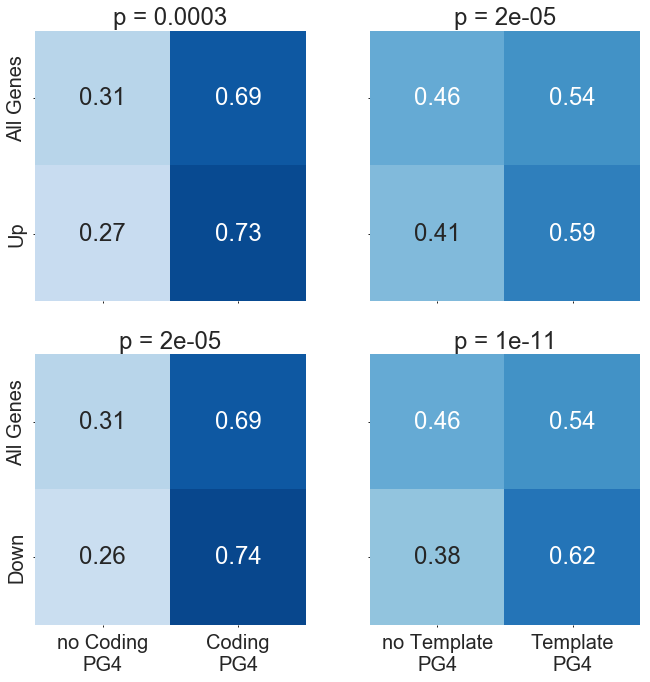

In [51]:
fig, axes = plt.subplots(figsize=(10, 10), nrows=2, ncols=2)

strand_g4 = [
    nmm_drought_g4.drop_duplicates('gene_id_nmm').coding_g4.astype(bool),
    nmm_drought_g4.drop_duplicates('gene_id_nmm').template_g4.astype(bool),
]


de_sets = [
    nmm_drought_g4.drop_duplicates('gene_id_nmm')['upreg_drought'].values,
    nmm_drought_g4.drop_duplicates('gene_id_nmm')['downreg_drought'].values
]

for j, (g4, strand) in enumerate(zip(strand_g4, ['Coding', 'Template'])):
    for i, (de, lab) in enumerate(zip(de_sets, ['Up', 'Down'])):
        nde = np.asarray([sum(~g4),
                          sum(g4)])
        dr = np.asarray([sum(~g4 & de),
                         sum(g4 & de)])
        nde = nde / nde.sum()
        exp = nde * dr.sum()
        _, p = stats.chisquare(dr, exp)
        dr = dr / dr.sum()
        mat = np.asarray([nde, dr])
        sns.heatmap(mat,
                    cmap='Blues',
                    annot=True,
                    square=True,
                    xticklabels=['no {}\nPG4'.format(strand),
                                 '{}\nPG4'.format(strand)],
                    yticklabels=['All Genes', lab],
                    ax=axes[i][j],
                    vmin=0.1, vmax=0.8,
                    cbar=False)
        axes[i][j].set_title('p = {:.1g}'.format(p))
for ax in axes.ravel():
    plt.setp(ax.get_yticklabels(), va='center')
for ax in axes[0]:
    ax.set_xticklabels(['', ''])
for ax in axes[:, 1]:
    ax.set_yticklabels(['', ''])
plt.tight_layout()
plt.savefig('drought_g4_presence_absence_chisquared.svg')
plt.show()